In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import levene
import statsmodels.api as sm
import warnings
from astropy.io import fits

%matplotlib inline

## Functions

In [4]:
def linear_f(x, m, b):
    return m*x+b

def apply_custom_style(title, xlabel, ylabel, style=1, x_data=None, y_data=None):
    """
    Apply a custom style to a Matplotlib plot.
    """
    if style == 1:
        # Set the ticks
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        plt.title(title, fontsize=16)
        plt.xlabel(xlabel, fontsize=14)
        plt.ylabel(ylabel, fontsize=14)
        plt.legend(fontsize=12, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

        # Add gridlines
        plt.grid(True, linestyle='--', alpha=0.6) # major gridlines
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1) # minor gridlines
        
        if x_data is not None:
            xlim_min = x_data.min()-0.02*np.abs(x_data.min())
            xlim_max = x_data.max()+0.02*np.abs(x_data.max())
            ax.set_xlim(xlim_min, xlim_max)  
            
            if all(x <= 0 for x in x_data):
                plt.gca().invert_xaxis()
            
        if y_data is not None:    
            ylim_min = y_data.min()-0.02*np.abs(y_data.min())
            ylim_max = y_data.max()+0.02*np.abs(y_data.max())
            ax.set_ylim(ylim_min, ylim_max)
        
        plt.tight_layout()  # Ensure proper spacing between subplots
    else:
        warnings.warn(f"Style = {style} is not an option. Choosing default style = 1.", UserWarning)
        style = 1
        
def z_to_d(z, z_err=0, units='Mpc'):
    """Converts redshift (z) to distance (d) in various units.
    Args:
        z (float): Redshift value.
        z_err (float): Error in redshift value (default is 0).
        units (str): Unit for the output distance ('ly', 'km', or 'Mpc', default is 'Mpc').

    Returns:
        tuple: A tuple containing the converted distance (d) and its error (d_err) in the specified units.
    """
    c = 299792458 * 1e-3  # Speed of light in km/s
    H_0 = 68.3  # Hubble's Constant in km/s/Mpc
    H_0_err = 1.5  # Hubble's Constant error in km/s/Mpc
    
    # Used when converting Mpc to other units
    conversion_factors = {
        'ly': 3.262e+6,
        'km': 3.086e+22,
        'Mpc': 1.0  
    }
    
    if units not in conversion_factors:
        raise ValueError("Not a valid unit. Try any of 'Mpc', 'ly', or 'km'.")
    
    conversion_factor = conversion_factors[units]
    d = c * z / H_0 * conversion_factor
    d_err = np.sqrt((z_err * c / H_0 * conversion_factor) ** 2 + (H_0_err * c * z / H_0 ** 2 * conversion_factor) ** 2)  # Errors of z and H_0 are treated independently.
    
    return d, d_err

## SAMI Query

This is the query used to collect data from Data Central.

Data may be queried here: https://datacentral.org.au/services/query/ <br>
Data may be searched here: https://datacentral.org.au/services/schema/#sami


Used 02/10/2023. Removed `VSIGMA_RE` and `ellip`. Added `epsMGE_Re` (ellip but different) and `LAMBDAR_RE_MGE`. Reason was because I thought VSIGMA_RE was a measure of rotational velocity, however, that is actually LAMBDAR_RE_MGE.

`SELECT 
    t1.CATID, t1.z_spec, t1.Mstar, t1.M_r, t1.r_e, 
    t2.SIGMA_RE, t2.SIGMA_RE_ERR, t2.LAMBDAR_RE_MGE, t2.LAMBDAR_RE_MGE_ERR,
    t3.TYPE, 
    t4.Age_RE, t4.Age_RE_ERR, 
    t5.SFR_RE, t5.SFR_RE_ERR,
    t6.WARNSKER, t6.WARNZ, t6.ISBEST,
    t7.epsMGE_Re
FROM 
    sami_dr3.InputCatGAMADR3 as t1
JOIN 
    sami_dr3.samiDR3Stelkin as t2 ON t2.CATID = t1.CATID
JOIN 
    sami_dr3.VisualMorphologyDR3 as t3 ON t3.CATID = t1.CATID
JOIN 
    sami_dr3.SSPAperturesDR3 as t4 ON t4.CATID = t1.CATID
JOIN 
    sami_dr3.EmissionLine1compDR3 as t5 ON t5.CATID = t1.CATID
JOIN 
    sami_dr3.CubeObs as t6 ON t6.CATID = t1.CATID
JOIN
	sami_dr3.MGEPhotomUnregDR3 as t7 ON t7.CATID = t1.CATID
WHERE 
    t3.TYPE IN (0, 0.5)
    AND t1.M_r > -100
    AND t2.SIGMA_RE > -100;`
    
### Notes on Collecting Data:
* Cannot download data more than 1000 rows from Datacentral as their *.tar.gz* files are corrupted.
* For some reason, using structure `WHERE NOT ( ___ IS NULL AND ___ IS NULL)` doesn't work... Therefore, I have resorted to using `>-100` as a way of restricting NaN values.

## Data Cleaning
- Only take values with error <5%?
- Delete duplicate rows
- Find a way to estimate M_r to get more data. Compare the accuracy. Maybe use .fits files if I can get the .tar.gz stuff to work.

Magnitude Filtering: Filtering galaxies by magnitude helps focus on galaxies that are bright enough to be well observed with the available instruments and resources.

Redshift Filtering: By selecting galaxies within a specific redshift range, astronomers can study objects at specific cosmic epochs and distances.
Also maybe choosing galaxies with low redshift space distortions.

Spectral Features: We might focus on galaxies that exhibit strong emission lines associated with specific elements or physical processes. This allows them to study phenomena such as star formation rates, chemical compositions, or the presence of active galactic nuclei.

### Note for Future:
- create a histogram showing how the number of galaxies change as we filter them out.

## Preliminary Data Cleaning for Faber-Jackson Relation Plotting

**Background:**
When obtaining data from DataCentral, we often encounter multiple CATIDs with varying values for the `AGE_RE` and `SFR_RE` columns. These columns are not essential for plotting the Faber-Jackson relation (FJR). Therefore, we follow these steps to clean the data:

1. **Drop Unnecessary Columns:** Initially, we eliminate the `AGE_RE` and `SFR_RE` columns since they are not used in FJR plotting. 


2. **Merge Identical Rows:** Subsequently, we merge rows with identical values, simplifying the dataset and avoiding redundancy.


3. **Handling Duplicate CATIDs:** In cases where there are duplicate CATIDs with different stellar kinematic information, we address this by dropping the duplicates from the dataframe.

This code is specifically designed for data preparation when plotting the Faber-Jackson relation, ensuring that the dataset is clean and ready for analysis.


In [3]:
# Drop the last 4 columns from original dataframe.
df = pd.read_csv('Query.csv')
WARNSKER_count = (df['WARNSKER'] == 1).sum()
df = filtered_df = df[df['WARNSKER'] != 1]
print(f"Removed {WARNSKER_count} rows flagged for problems with stellar kinematics.")
df_dropped = new_df = df.drop(columns=["Age_RE", "Age_RE_ERR", "SFR_RE", "SFR_RE_ERR"])

# Merge rows with identical values
df_merged = df_dropped.drop_duplicates(keep='first')

# Show rows with duplicate CATIDs and different values. Ideally, this should return an empty dataframe.
duplicate_rows = df_merged[df_merged.duplicated(subset=['CATID'], keep=False)]

# Find the CATIDs to delete and Filter out rows with CATIDs in catids_to_delete
catids_to_delete = duplicate_rows['CATID'].unique()
df_merged = df_merged[~df_merged['CATID'].isin(catids_to_delete)].reset_index(drop=True)
df_merged.to_csv('FJR.csv', index=False)
df_merged

Removed 0 rows flagged for problems with stellar kinematics.


,CATID,z_spec,Mstar,M_r,r_e,SIGMA_RE,SIGMA_RE_ERR,LAMBDAR_RE_MGE,LAMBDAR_RE_MGE_ERR,TYPE,WARNSKER,WARNZ,ISBEST,epsMGE_Re
0,7289,0.08682,11.12,-22.370001,4.96,205.145279,1.877292,0.055964,0.006931,0.5,0,0,1,0.212124
1,7839,0.04749,11.05,-22.100000,6.95,195.761124,1.614042,0.301712,0.004571,0.5,0,0,1,0.210108
2,7969,0.08554,11.02,-22.120001,5.17,249.797653,2.451845,0.044866,0.006665,0.5,0,0,1,0.097907
3,8488,0.01996,9.51,-18.360001,1.42,74.450806,1.093145,NaN,NaN,0.0,0,0,1,0.045429
4,8865,0.07314,10.66,-21.160000,2.50,214.679764,2.817183,NaN,NaN,0.0,0,0,1,0.041806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,618947,0.05592,10.59,-21.040001,2.29,154.557480,1.459691,0.163051,0.009242,0.5,0,0,1,0.038525
223,619258,0.05711,10.07,-19.900000,1.61,154.294449,2.149503,NaN,NaN,0.0,0,0,1,0.117071
224,622350,0.08733,11.10,-22.290001,4.89,204.201096,2.767676,0.076269,0.010844,0.0,0,0,1,0.053514
225,623017,0.06996,10.85,-21.709999,4.65,164.374863,2.595616,0.285849,0.010110,0.5,0,0,1,0.034835


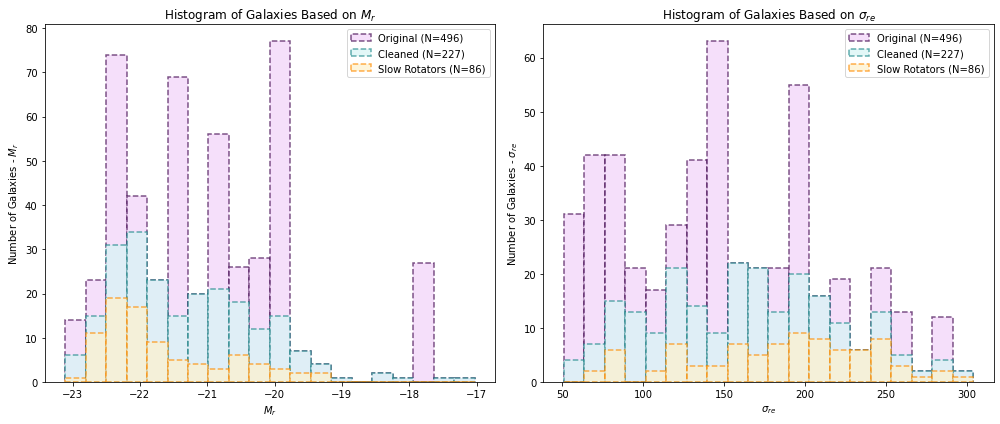

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('FJR.csv')
df_filt = df[df['LAMBDAR_RE_MGE'] < (0.08 + 0.25 * df['epsMGE_Re'])]

# Create a figure with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bins = np.linspace(min(df_merged['M_r'].min(), df_filt['M_r'].min()), max(df_merged['M_r'].max(), df_filt['M_r'].max()), 21)
# Create a histogram for M_r on the first subplot with a dashed colored line
ax1.hist(df_dropped['M_r'], bins=20, color='#f1d2f9', alpha=0.7, label=f'Original (N={len(df_dropped["M_r"])})', edgecolor='#450c53', linestyle='--', linewidth=1.5)
ax1.hist(df_merged['M_r'], bins=20, color='#d6f5f5', alpha=0.7, label=f'Cleaned (N={len(df_merged["M_r"])})', edgecolor='#218a8c', linestyle='--', linewidth=1.5)
ax1.hist(df_filt['M_r'], bins=bins, color='#fef2cd', alpha=0.7, label=f'Slow Rotators (N={len(df_filt["M_r"])})', edgecolor='darkorange', linestyle='--', linewidth=1.5)

# Set labels and title for the first subplot
ax1.set_xlabel('$M_r$')
ax1.set_ylabel('Number of Galaxies - $M_r$')
ax1.set_title('Histogram of Galaxies Based on $M_r$')
ax1.legend()

bins = np.linspace(min(df_merged['SIGMA_RE'].min(), df_filt['SIGMA_RE'].min()), max(df_merged['SIGMA_RE'].max(), df_filt['SIGMA_RE'].max()), 21)
# Create a histogram for SIGMA_RE on the second subplot with a dashed colored line
ax2.hist(df_dropped['SIGMA_RE'], bins=20, color='#f1d2f9', alpha=0.7, label=f'Original (N={len(df_dropped["SIGMA_RE"])})', edgecolor='#450c53', linestyle='--', linewidth=1.5)
ax2.hist(df_merged['SIGMA_RE'], bins=20, color='#d6f5f5', alpha=0.7, label=f'Cleaned (N={len(df_merged["SIGMA_RE"])})', edgecolor='#218a8c', linestyle='--', linewidth=1.5)
ax2.hist(df_filt['SIGMA_RE'], bins=bins, color='#fef2cd', alpha=0.7, label=f'Slow Rotators (N={len(df_filt["SIGMA_RE"])})', edgecolor='darkorange', linestyle='--', linewidth=1.5)

# Set labels and title for the second subplot
ax2.set_xlabel('$\sigma_{re}$')
ax2.set_ylabel('Number of Galaxies - $\sigma_{re}$')
ax2.set_title('Histogram of Galaxies Based on $\sigma_{re}$')
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots side by side
plt.savefig('plots/DataCleaningHistogram.png', dpi=300, bbox_inches='tight')
plt.show()


## Preliminary Data Cleaning for Galaxy Age Plotting

**Background:**
When obtaining data from DataCentral, we often encounter multiple CATIDs with varying values for the `AGE_RE` and `SFR_RE` columns. Sometimes these values are close together, and so the mean can be taken. Othertimes, the values are so far off it becomes impossible to determine which is the true value and are thus removed from the dataframe.

Thus, we follow these steps to clean the data:

1. **Calculate Average 'Age_RE':** We group the DataFrame by 'CATID' and compute the mean of the 'Age_RE' values (line 5).


2. **Compute 'Age_RE' Range by CATID:** Next, we create an array that tracks the range of 'Age_RE' values for each 'CATID' (line 8).


3. **Create Filtering Mask:** We generate a mask to flag rows in the array where the range of 'Age_RE' is less than 10% of the average 'Age_RE'. This step is crucial to exclude data with significantly different values from the average (line 11).


4. **Apply the Mask and Delete Rows:** Using the mask, we filter the DataFrame, retaining only rows where the range of 'Age_RE' is within the 10% threshold of the average 'Age_RE' (line 13).

This code is specifically designed for data preparation when plotting galaxy data with age or star formation rates, ensuring that the dataset is clean and ready for analysis.

In [4]:
import pandas as pd

# Assuming you've already loaded the CSV into df
df = pd.read_csv('Query.csv')
average_age_re = df.groupby('CATID')['Age_RE'].transform('mean')

# Calculate the range of Age_RE values for each CATID
range_age_re = df.groupby('CATID')['Age_RE'].transform(lambda x: x.max() - x.min())

# Create a mask to filter rows based on the condition
mask = range_age_re < 0.1 * average_age_re

# Apply the mask to select rows that meet the condition
df_filtered = df[mask]

# Drop duplicates based on CATID
df_filtered = df_filtered.drop_duplicates(subset='CATID')

# df_AGE now contains the filtered and merged rows
df_AGE = df_filtered.reset_index(drop=True)
df_AGE.to_csv('FJR_withAGE.csv', index=False)
# Print df_AGE
display(df_AGE)

,CATID,z_spec,Mstar,M_r,r_e,SIGMA_RE,SIGMA_RE_ERR,LAMBDAR_RE_MGE,LAMBDAR_RE_MGE_ERR,TYPE,Age_RE,Age_RE_ERR,SFR_RE,SFR_RE_ERR,WARNSKER,WARNZ,ISBEST,epsMGE_Re
0,7289,0.08682,11.12,-22.370001,4.96,205.145279,1.877292,0.055964,0.006931,0.5,5.487696,1.974722,0.528197,0.300727,0,0,1,0.212124
1,7839,0.04749,11.05,-22.100000,6.95,195.761124,1.614042,0.301712,0.004571,0.5,5.487696,1.090906,0.549011,0.182587,0,0,1,0.210108
2,7969,0.08554,11.02,-22.120001,5.17,249.797653,2.451845,0.044866,0.006665,0.5,7.932133,3.112356,0.017530,NaN,0,0,1,0.097907
3,8488,0.01996,9.51,-18.360001,1.42,74.450806,1.093145,NaN,NaN,0.0,6.751340,4.683753,0.000357,NaN,0,0,1,0.045429
4,8865,0.07314,10.66,-21.160000,2.50,214.679764,2.817183,NaN,NaN,0.0,11.465421,5.301138,0.024287,NaN,0,0,1,0.041806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,618947,0.05592,10.59,-21.040001,2.29,154.557480,1.459691,0.163051,0.009242,0.5,9.536522,3.641947,0.005136,NaN,0,0,1,0.038525
235,619258,0.05711,10.07,-19.900000,1.61,154.294449,2.149503,NaN,NaN,0.0,5.746323,4.149974,0.000578,NaN,0,0,1,0.117071
236,622350,0.08733,11.10,-22.290001,4.89,204.201096,2.767676,0.076269,0.010844,0.0,7.751576,3.986750,0.040210,NaN,0,0,1,0.053514
237,623017,0.06996,10.85,-21.709999,4.65,164.374863,2.595616,0.285849,0.010110,0.5,9.985964,4.432420,0.067994,0.038636,0,0,1,0.034835


# Faber-Jackson Grouped by Effective Radius `r_e`
Here, the Faber-Jackson relation and the residuals are plotted grouped by the galaxy's effective radius `r_e`.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


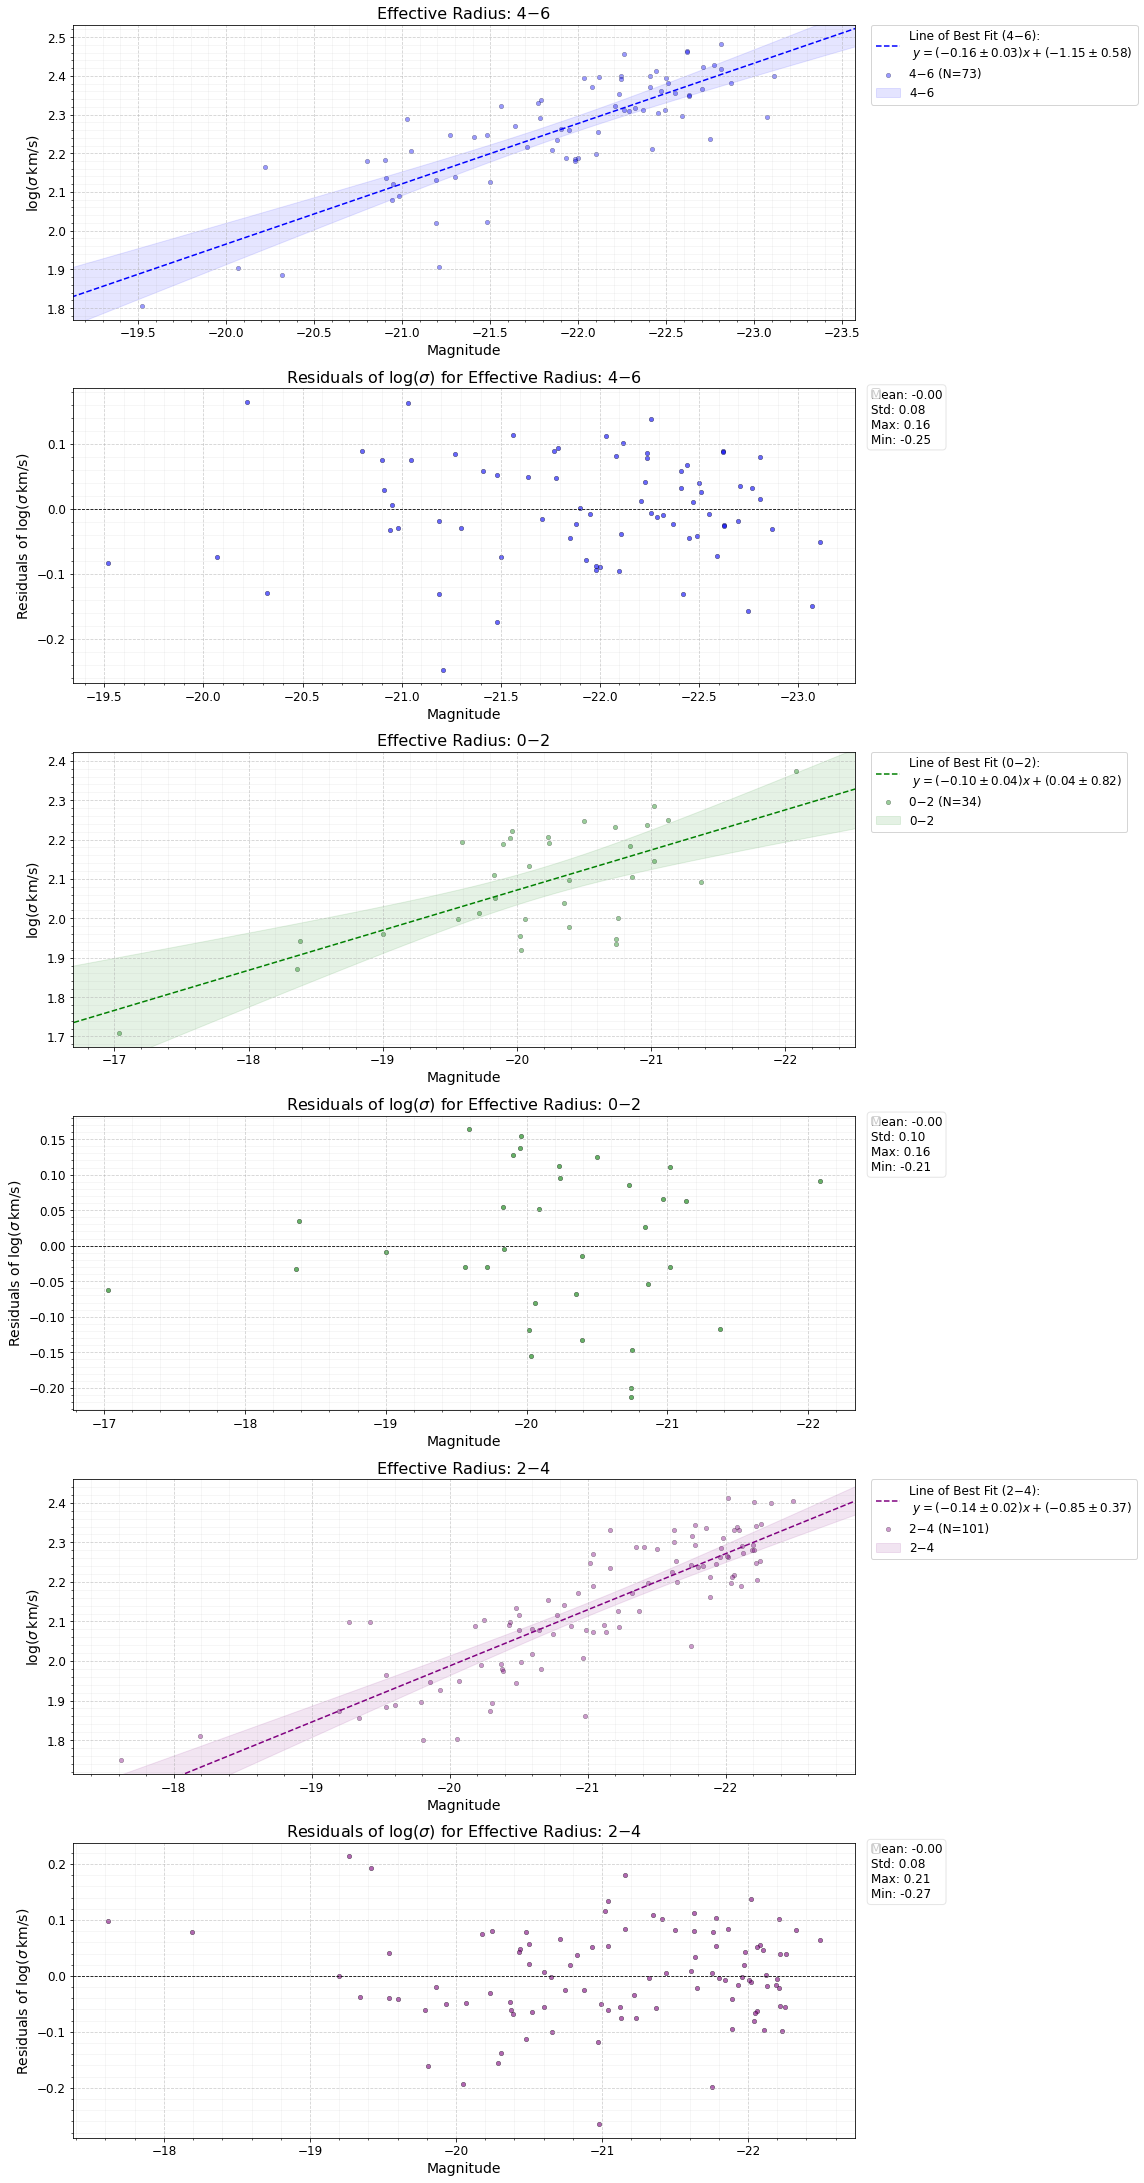

               sum_sq     df         F    PR(>F)
r_e_bin      0.172819    4.0  5.748919  0.000838
M_r               NaN    1.0       NaN       NaN
M_r:r_e_bin  0.071994    4.0  2.394932  0.069221
Residual     1.645846  219.0       NaN       NaN


/Users/calebburke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/Users/calebburke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/calebburke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1917: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/Users/calebburke/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '


In [17]:
df = pd.read_csv('FJR.csv')
bin_edges = [0, 2, 4, 6, 8, float('inf')]
bin_labels = ['0−2', '2−4', '4−6', '6−8', '>8']
df['r_e_bin'] = pd.cut(df['r_e'], bins=bin_edges, labels=bin_labels, right=False)

x_data = df['M_r']
y_data = np.log10(df['SIGMA_RE'])
colors = ['b', 'r', 'g', 'purple', 'orange']
group_col = df['r_e_bin']
values = group_col.unique()

# Create a figure
fig = plt.figure(figsize=(16, 40))

# Create 6 subplots in a 2x3 grid
subplots_created = 0
for i, value in enumerate(values):
    mask = group_col == value  # This mask is used to filter out certain data to create groups.
    count = sum(mask)
    label = str(value)
    
    # Only create a subplot if count >= 20
    if count >= 20:
        subplots_created += 1
        ax = fig.add_subplot(2*len(values), 1, subplots_created)
        x_mask = x_data[mask]
        y_mask = y_data[mask]
        count = len(x_mask)
        
        ax.scatter(x_mask, y_mask, s=20, color=colors[i], alpha=0.4, edgecolors='k', linewidths=0.5, label=f'{label} (N={count})')
        
        # Find the minimum and maximum x values in the data. Then add a constant term to the x_data for regression
        x_min = x_mask.min()
        x_max = x_mask.max()
        x_with_const = sm.add_constant(x_mask)

        # Generate a range of x values for the confidence interval
        x_linspace = np.linspace(x_min-0.1*np.abs(x_min), x_max+0.1*np.abs(x_max), 500)
        x_linspace_with_const = sm.add_constant(x_linspace)

        # Fit a linear regression model to the data
        model_ci = sm.OLS(y_mask, x_with_const).fit()

        # Get predictions and confidence intervals for the regression. Snake_case "ci" for confidence interval"
        predictions_ci = model_ci.get_prediction(x_linspace_with_const)
        conf_interval = predictions_ci.conf_int()
        lower_bound_ci = conf_interval[:, 0]
        upper_bound_ci = conf_interval[:, 1]

        # Plot the confidence interval
        ax.fill_between(x_linspace, lower_bound_ci, upper_bound_ci, color=colors[i], alpha=0.1, label=label)

        # Calculate uncertainty in slope and intercept. Snake_case "lb" for lower bound; "ub" for upper bound.
        # These are points on the confidence intervals used to calculate uncertainty bounds.
        point1 = [x_linspace[0], lower_bound_ci[0]]
        point2 = [x_linspace[-1], upper_bound_ci[-1]]
        point3 = [x_linspace[0], upper_bound_ci[0]]
        point4 = [x_linspace[-1], lower_bound_ci[-1]]

        slope_lb = (lower_bound_ci[-1] - upper_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])
        slope_ub = (upper_bound_ci[-1] - lower_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])
        slope_uncertainty = np.abs(slope_lb - slope_ub) / 2
        m_unc = slope_uncertainty

        intercept_lb = point2[1] - slope_ub * point2[0]
        intercept_ub = point4[1] - slope_lb * point4[0]
        intercept_uncertainty = np.abs(intercept_lb - intercept_ub) / 2
        b_unc = intercept_uncertainty

        # Use curve_fit function from scipy.optimize to fit data to a linear function
        popt, pcov = curve_fit(linear_f, x_mask, y_mask, p0=[1,4])
        m, b = popt
        fit_params = [m, b]

        # Generate x and y values for best fit line.
        x_min = x_mask.min()
        x_max = x_mask.max()
        x_fit = np.linspace(x_min-0.1*np.abs(x_min), x_max+0.1*np.abs(x_max), 1000)
        y_fit = linear_f(x_fit, m, b)
        
        ax.plot(x_fit, y_fit, label=f'Line of Best Fit ({label}):\n $y=({fit_params[0]:.2f}\pm{m_unc:.2f})x+({fit_params[1]:.2f}\pm{b_unc:.2f})$', color=colors[i], linestyle='--')
    
        apply_custom_style(title=f'Effective Radius: {value}', xlabel='Magnitude', ylabel='$\log(\sigma \, \mathrm{ km/s})$', style=1, x_data=x_data[mask], y_data=y_data[mask])
        
        subplots_created += 1
        ax = fig.add_subplot(2*len(values), 1, subplots_created)
                
        residuals_x = x_mask
        residuals_y = y_mask - linear_f(x_mask, fit_params[0], fit_params[1])

        # Calculate residual statistics
        mean_res = np.mean(residuals_y)
        std_res = np.std(residuals_y)
        max_res = np.max(residuals_y)
        min_res = np.min(residuals_y)

        # Create a subplot for each set of residuals
        ax.scatter(residuals_x, residuals_y, s=20, color=colors[i], alpha=0.6, edgecolors='k', linewidths=0.5)
        ax.axhline(0, color='k', linestyle='--', linewidth=0.8)

        # Add residual statistics to the legend
        stats_text = f"Mean: {mean_res:.2f}\nStd: {std_res:.2f}\nMax: {max_res:.2f}\nMin: {min_res:.2f}"
        ax.text(1.02, 1.0, stats_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.8'))        
                
        apply_custom_style(title=f'Residuals of $\log(\sigma)$ for Effective Radius: {value}', xlabel='Magnitude', ylabel='Residuals of $\log(\sigma \, \mathrm{ km/s})$', style=1)
        
        # Invert x-axis
        if all(x <= 0 for x in x_data):
            plt.gca().invert_xaxis()
            
plt.savefig('plots/FJR_by_RE_and_residuals.png', dpi=300, bbox_inches='tight')
plt.show()


# Fit linear regression models for each species
model = ols('np.log10(df["SIGMA_RE"]) ~ M_r * r_e_bin', data=df).fit()


# Perform ANOVA to test if slopes are significantly different
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


## Faber-Jackson Relation Information

The Faber-Jackson relation can be expressed as

$$
L \propto \sigma_{0}^{4}
$$

where $\sigma_0$ is the central value for the radial-velocity dispersion, and $L$ is the galaxy's luminosity. By taking the $\log$ of both sides and writing $L$ in terms of solar masses, we can simplify the Faber-Jackson relation as:

$$
\begin{align*}
    L &\propto \sigma_{0}^{4} \\
    \log_{10}\left(\frac{L}{L_☉}\right) &= \log_{10}(\sigma_{0}^4) \\
    M &= a\log_{10}\sigma + b
\end{align*}
$$

where we expect $a=4$ and $b=0$.

There is a discussion to improve the Faber-Jackson relation to produce a tighter relation by introducing the effective radius $r_e$ (see <i>An Introduction to Modern Astrophysics</i>, page 998), giving:

$$
L \propto \sigma_{0}^{2.65}r_{e}^{0.65}
$$

which when written as a function of absolute magnitude $M$, becomes

$$
M = a\log_{10}\sigma + b\log_{10} r_e + c.
$$

A 3D plot featuring a best-fit plane illustrates the predicted of a planar trend.

### 3D Plot of $σ$, $r_e$, and $M_r$. 

#### 3D Plot of the Fundamental Plate
Here, the fundamental plane is plotted. I should double check that this is done correctly, I feel like it hasn't...

<IPython.core.display.Javascript object>


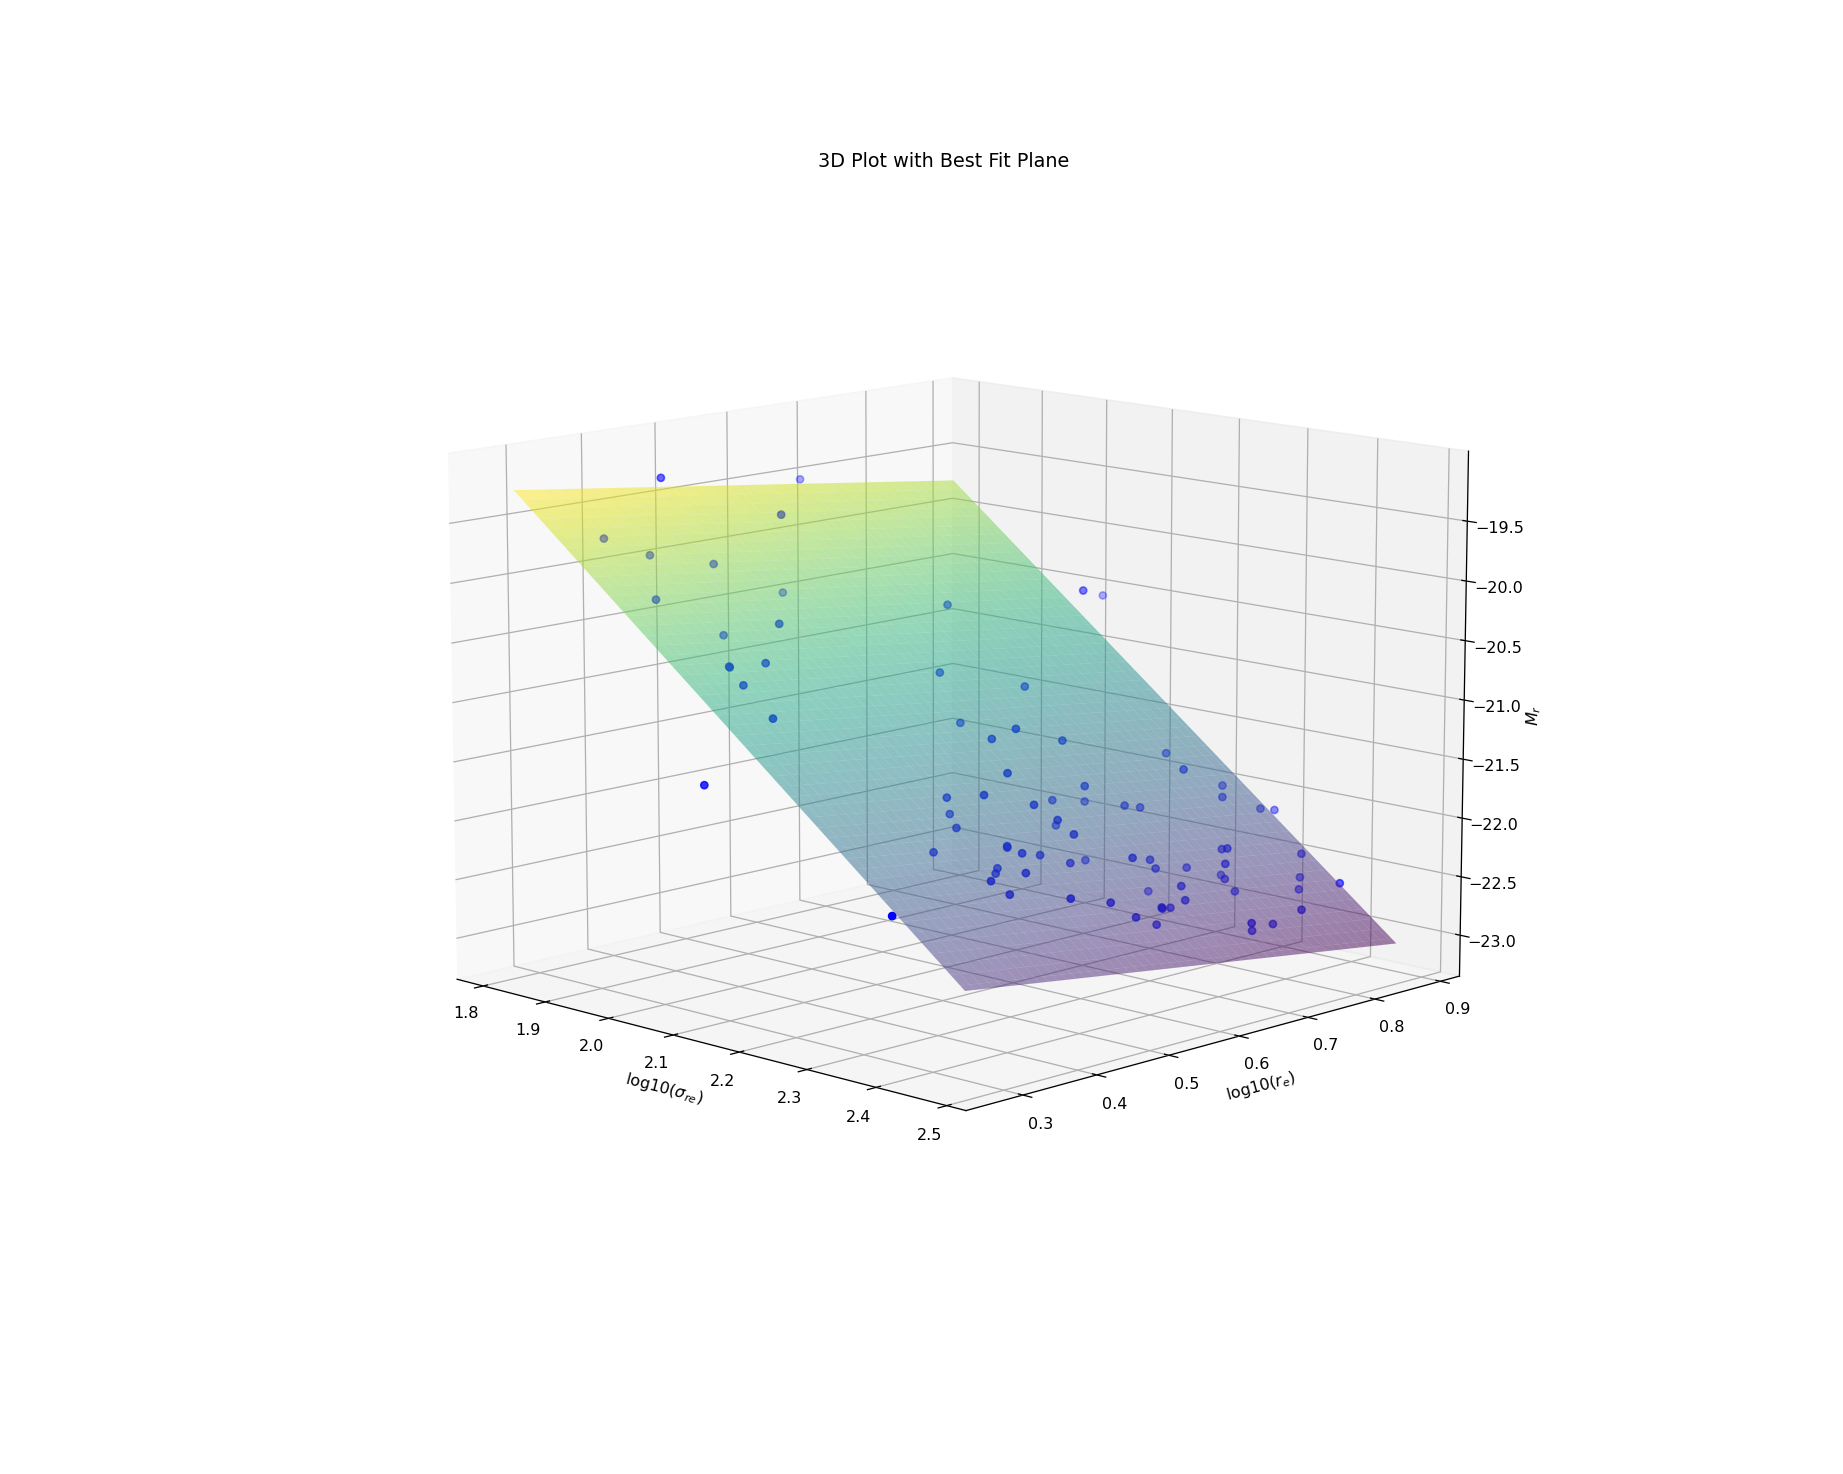

The planar equation is: Mr = -4.94 * log10(σre) + -0.86 * log10(re) + -10.07


In [108]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares

%matplotlib notebook
df = pd.read_csv('FJR.csv')
# Select slow rotators using the Cappellari (2016) selection box based on MGE measurements of λRe and ellipticity.
df = df[df['LAMBDAR_RE_MGE'] < (0.08 + 0.25 * df['epsMGE_Re'])]


# Replace this with your actual data
x = np.log10(df['SIGMA_RE'])
y = np.log10(df['r_e'])
z = df['M_r']

# Define the function for the plane to fit
def plane(params, x, y, z):
    a, b, c = params
    return a * x + b * y + c - z

# Initial guess for the plane parameters
initial_guess = [1, 1, 1]

# Fit the plane to the data
result = least_squares(plane, initial_guess, args=(x, y, z))

# Extract the fitted plane parameters
a, b, c = result.x

# Create a meshgrid for plotting the plane
x_range = np.linspace(min(x), max(x), 100)
y_range = np.linspace(min(y), max(y), 100)
xx, yy = np.meshgrid(x_range, y_range)
zz = a * xx + b * yy + c

# Create the 3D plot with a larger figure size
fig = plt.figure(figsize=(10, 8))  # You can adjust the width and height as needed
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points
ax.scatter(x, y, z, c='b', marker='o', label='Data Points')

# Plot the fitted plane
ax.plot_surface(xx, yy, zz, alpha=0.5, cmap='viridis', label='Fitted Plane')

# Set labels and title
ax.set_xlabel('log10($\sigma_{re}$)')
ax.set_ylabel('log10($r_e$)')
ax.set_zlabel('$M_r$')
ax.set_title('3D Plot with Best Fit Plane')

# Show the plot
plt.show()

a, b, c = result.x
print(f"The planar equation is: Mr = {a:.2f} * log10(σre) + {b:.2f} * log10(re) + {c:.2f}")

In [109]:
%matplotlib inline

## Faber-Jackson Relation by Morphology

Below, this code generates scatterplots for the Faber-Jackson Relation (FJR) and its residuals, focusing on different morphological categories of galaxies, specifically *0 (E)* and *0.5 (E/S0)*. In this context, a *0 (E)* type represents a confidently elliptical galaxy, while *0.5 (E/S0)* types exhibit contentious elliptical characteristics along with some atypical features not typically found in regular elliptical galaxies.

The code follows these steps for each morphological category:
   - It creates a scatter plot of the data points, including labels and counts.
   - A confidence interval is computed and visualised as a shaded region.
   - The best-fit line for the data points is calculated and plotted, taking into account uncertainties in both slope and intercept.

The resulting main plot is saved as an image file and displayed.

Additionally, residual plots are generated for each morphological group. These residual plots highlight the differences between observed data and the best-fit line. To assess the variation in the FJR across different morphological categories, a Levene's test is conducted to compare variances. The test results indicate that there is no statistically significant difference in the tightness (standard deviation) between morphological groups.

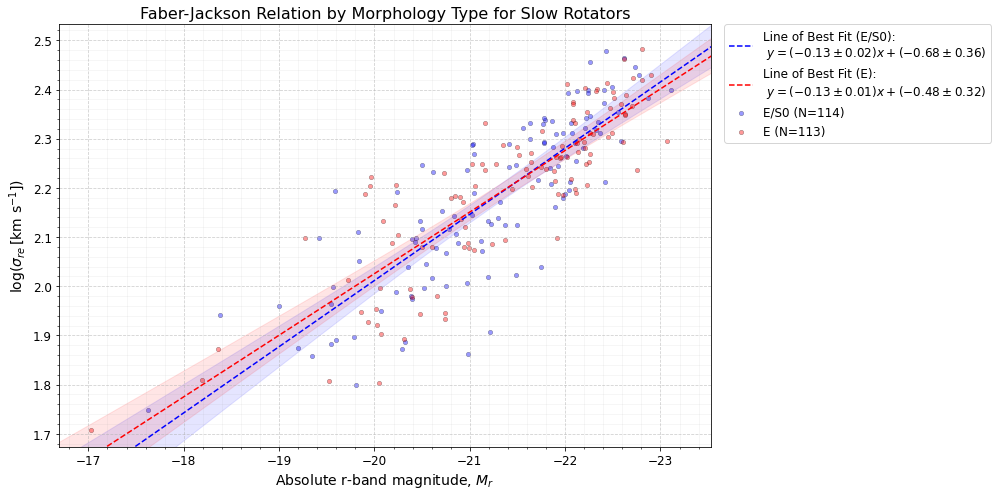

No handles with labels found to put in legend.
No handles with labels found to put in legend.


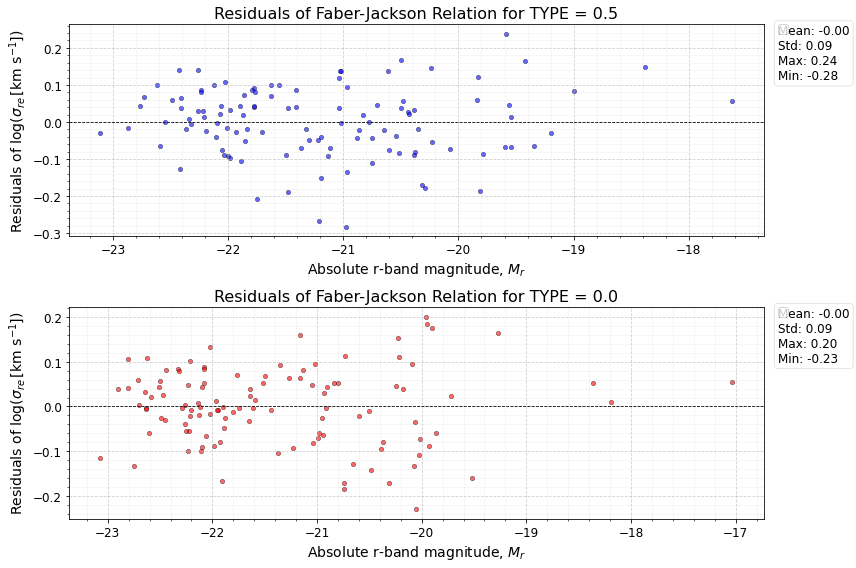

There is no significant difference between the standard deviations of residuals when grouping by E and E/S0 with p-value = 0.334 > 0.05


In [28]:
df = pd.read_csv('FJR.csv')

# Define variables and parameters for plotting
x_data = df['M_r']
y_data = np.log10(df['SIGMA_RE'])
group_col = df['TYPE']
title = 'Faber-Jackson Relation by Morphology Type'
xlabel = 'Absolute r-band magnitude, $M_r$'
ylabel = '$\log(\sigma_{re} \, [\mathrm{km\ s}^{-1}])$'
colors = ['b', 'r', 'g', 'purple', 'orange']

# Clean the data by removing rows with missing values
mask = pd.notna(x_data) & pd.notna(y_data)
df = df[mask]

# Find unique group categories
values = group_col.unique()

# Initialise the main plot
fig, ax = plt.subplots(figsize=(14, 7))

# Initialise a dictionary to store fit parameters
fit_params_dict = {}
# Iterate over group categories
for i, value in enumerate(values):
    # Create a mask to filter data for each group
    mask = group_col == value
    
    # Define the label based on the value
    if value == 0:
        label = "E"
    elif value == 0.5:
        label = "E/S0"
    else:
        label = str(value)
    
    ##### PLOT DATA #####
    # Select data points corresponding to the current group
    x_masked = x_data[mask]
    y_masked = y_data[mask]
    count = len(x_masked)

    # Add data points to the plot
    ax.scatter(x_masked, y_masked, s=20, color=colors[i], alpha=0.4, edgecolors='k', linewidths=0.5, label=f"{label} (N={count})")

    ##### CONFIDENCE INTERVAL #####
    x_range = 0.8 * np.abs(x_masked.max() - x_masked.min()) # Determine the x-axis range for plotting
    x_linspace = np.linspace(x_masked.min() - x_range, x_masked.max() + x_range, 500) # Create evenly spaced x-values for prediction
    x_with_const = sm.add_constant(x_masked) # Add a constant term to the x-values for the regression model
    model_ci = sm.OLS(y_masked, x_with_const).fit() # Fit a linear regression model to the data
    x_linspace_with_const = sm.add_constant(x_linspace) # Add a constant term to the x-values for the prediction
    predictions_ci = model_ci.get_prediction(x_linspace_with_const) # Generate predictions and calculate the confidence interval

    # Extract the lower and upper bounds of the confidence interval
    conf_interval = predictions_ci.conf_int()
    lower_bound_ci = conf_interval[:, 0]
    upper_bound_ci = conf_interval[:, 1]

    # Plot the confidence interval as a shaded region
    ax.fill_between(x_linspace, lower_bound_ci, upper_bound_ci, color=colors[i], alpha=0.1)

    ##### UNCERTAINTY OF BEST FIT #####
    # The uncertainty in slope and intercept is based on confidence interval points
    # Define four points on the confidence interval
    point1 = [x_linspace[0], lower_bound_ci[0]]
    point2 = [x_linspace[-1], upper_bound_ci[-1]]
    point3 = [x_linspace[0], upper_bound_ci[0]]
    point4 = [x_linspace[-1], lower_bound_ci[-1]]

    # Calculate the lower and upper bounds of the slope
    slope_lb = (lower_bound_ci[-1] - upper_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])
    slope_ub = (upper_bound_ci[-1] - lower_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])

    # Calculate the uncertainty in the slope
    slope_uncertainty = np.abs(slope_lb - slope_ub) / 2
    m_unc = slope_uncertainty  # Store slope uncertainty as 'm_unc'

    # Calculate the lower and upper bounds of the intercept
    intercept_lb = point2[1] - slope_ub * point2[0]
    intercept_ub = point4[1] - slope_lb * point4[0]

    # Calculate the uncertainty in the intercept
    intercept_uncertainty = np.abs(intercept_lb - intercept_ub) / 2
    b_unc = intercept_uncertainty  # Store intercept uncertainty as 'b_unc'

    ##### BEST FIT LINE #####
    popt, pcov = curve_fit(linear_f, x_masked, y_masked, p0=[1, 1])
    m, b = popt
    x_fits = np.linspace(x_masked.min() - 0.1 * np.abs(x_masked.min()), x_masked.max() + 0.1 * np.abs(x_masked.max()), 1000)
    y_fits = linear_f(x_fits, m, b)
    fit_params = [m, b]

    # Plot the best fit line with fit parameter uncertainties
    ax.plot(x_fits, y_fits, label=f'Line of Best Fit ({label}):\n $y=({fit_params[0]:.2f}\pm{m_unc:.2f})x+({fit_params[1]:.2f}\pm{b_unc:.2f})$', color=colors[i], linestyle='--')
    
    # Store fit parameters for each group in a dictionary
    fit_params_dict[value] = fit_params  

# Apply custom style to the main plot
apply_custom_style(title=title, xlabel=xlabel, ylabel=ylabel, style=1, x_data=x_data[mask], y_data=y_data[mask])

# Save and display the main plot
plt.savefig('plots/FJR_by_TYPE_All.png', dpi=300, bbox_inches='tight')
plt.show()

##### RESIDUAL PLOT #####
# Plot residuals for each group
residuals_all = []
residuals_bygroup = []
fig = plt.figure(figsize=(12, 8))
for i, value in enumerate(values):
    ax = fig.add_subplot(2, 1, i+1) 
    mask = group_col == value  
    fit_param = fit_params_dict[value]  
    
    residuals_x = x_data[mask]
    residuals_y = y_data[mask] - linear_f(x_data[mask], fit_param[0], fit_param[1])
    residuals_all.extend(residuals_y)
    residuals_bygroup.append(residuals_y)

    # Calculate residual statistics
    mean_res = np.mean(residuals_y)
    std_res = np.std(residuals_y)
    max_res = np.max(residuals_y)
    min_res = np.min(residuals_y)

    # Create a subplot for each set of residuals
    ax.scatter(residuals_x, residuals_y, s=20, color=colors[i], alpha=0.6, edgecolors='k', linewidths=0.5)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.8)

    # Add residual statistics to the legend
    stats_text = f"Mean: {mean_res:.2f}\nStd: {std_res:.2f}\nMax: {max_res:.2f}\nMin: {min_res:.2f}"
    ax.text(1.02, 1.0, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.8'))

    apply_custom_style(title = f'Residuals of Faber-Jackson Relation for TYPE = {value}', xlabel=xlabel, ylabel='Residuals of '+ylabel, style=1)

# Save and display the residual plots
plt.savefig('plots/FJR_by_TYPE_All_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

##### STATISTICAL TEST OF VARIANCE #####
# Perform Levene's test to compare variances
statistic, p_value = levene(residuals_bygroup[0], residuals_bygroup[1])

# Check if the p-value is significant (e.g., p < 0.05)
alpha = 0.05
if p_value < alpha:
    print(f"There is a significant difference between the standard deviations of residuals when grouping by E and E/S0 with p-value = {p_value:.3f} < 0.05.")
else:
    print(f"There is no significant difference between the standard deviations of residuals when grouping by E and E/S0 with p-value = {p_value:.3f} > 0.05")

## Faber-Jackson Relation by Morphology (Slow Rotators)

This section is the same as the previous, however, filtered to only include slow rotating elliptical galaxies. Slow rotators are selected on the criteria of Cappellari (2016) based on MGE measurements of $λ_{Re}$ and ellipticity: 

$$
\lambda_{Re} < 0.08 + \frac{e}{4}.
$$

Similarly, the test results indicate that there is no statistically significant difference in the tightness (standard deviation) between morphological groups for slow rotating ellipticals.

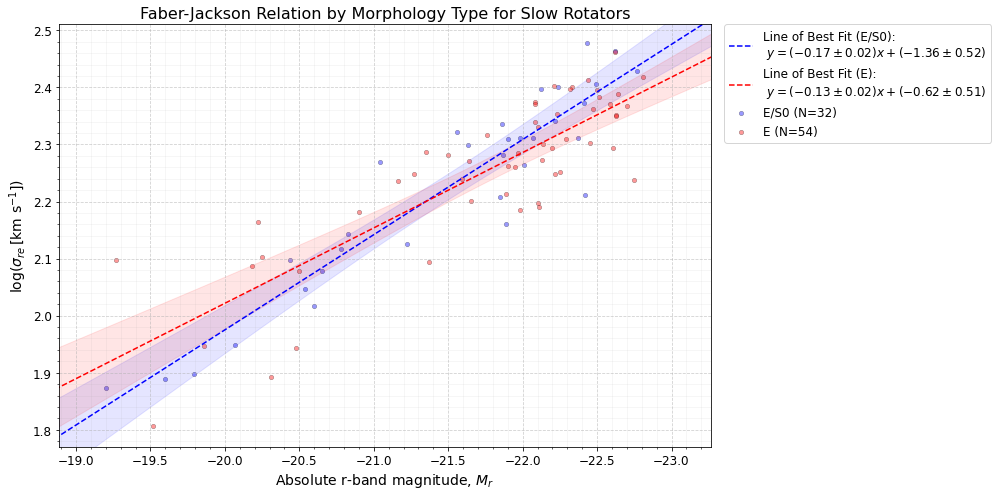

No handles with labels found to put in legend.
No handles with labels found to put in legend.


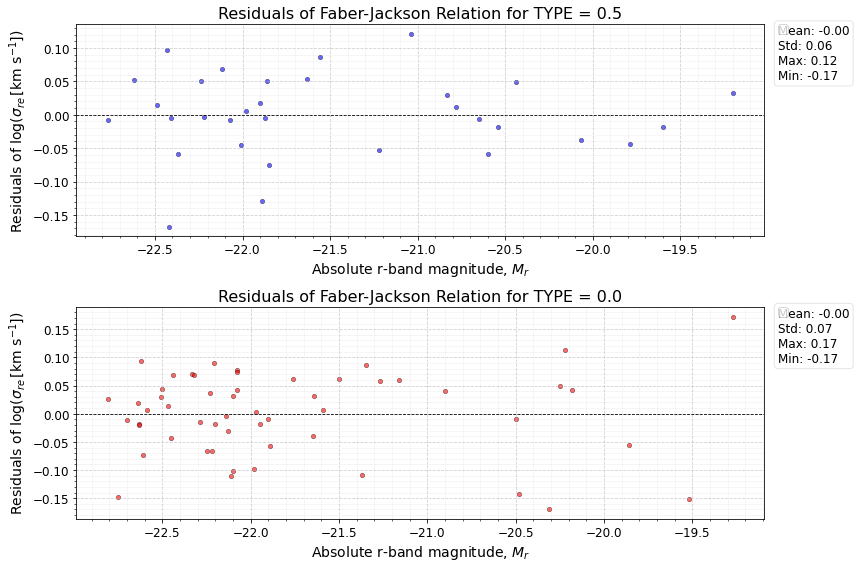

There is no significant difference between the standard deviations of residuals when grouping by E and E/S0 for slow rotators with p-value = 0.207 > 0.05


In [27]:
df = pd.read_csv('FJR.csv')
# Select slow rotators using the Cappellari (2016) selection box based on MGE measurements of λRe and ellipticity.
df = df[df['LAMBDAR_RE_MGE'] < (0.08 + 0.25 * df['epsMGE_Re'])]

# Define variables and parameters for plotting
x_data = df['M_r']
y_data = np.log10(df['SIGMA_RE'])
group_col = df['TYPE']
title = 'Faber-Jackson Relation by Morphology Type for Slow Rotators'
xlabel = 'Absolute r-band magnitude, $M_r$'
ylabel = '$\log(\sigma_{re} \, [\mathrm{km\ s}^{-1}])$'
colors = ['b', 'r', 'g', 'purple', 'orange']

# Clean the data by removing rows with missing values
mask = pd.notna(x_data) & pd.notna(y_data)
df = df[mask]

# Find unique group categories
values = group_col.unique()

# Initialise the main plot
fig, ax = plt.subplots(figsize=(14, 7))

# Initialise a dictionary to store fit parameters
fit_params_dict = {}
# Iterate over group categories
for i, value in enumerate(values):
    # Create a mask to filter data for each group
    mask = group_col == value
    
    # Define the label based on the value
    if value == 0:
        label = "E"
    elif value == 0.5:
        label = "E/S0"
    else:
        label = str(value)
    
    ##### PLOT DATA #####
    # Select data points corresponding to the current group
    x_masked = x_data[mask]
    y_masked = y_data[mask]
    count = len(x_masked)

    # Add data points to the plot
    ax.scatter(x_masked, y_masked, s=20, color=colors[i], alpha=0.4, edgecolors='k', linewidths=0.5, label=f"{label} (N={count})")

    ##### CONFIDENCE INTERVAL #####
    x_range = 0.8 * np.abs(x_masked.max() - x_masked.min()) # Determine the x-axis range for plotting
    x_linspace = np.linspace(x_masked.min() - x_range, x_masked.max() + x_range, 500) # Create evenly spaced x-values for prediction
    x_with_const = sm.add_constant(x_masked) # Add a constant term to the x-values for the regression model
    model_ci = sm.OLS(y_masked, x_with_const).fit() # Fit a linear regression model to the data
    x_linspace_with_const = sm.add_constant(x_linspace) # Add a constant term to the x-values for the prediction
    predictions_ci = model_ci.get_prediction(x_linspace_with_const) # Generate predictions and calculate the confidence interval

    # Extract the lower and upper bounds of the confidence interval
    conf_interval = predictions_ci.conf_int()
    lower_bound_ci = conf_interval[:, 0]
    upper_bound_ci = conf_interval[:, 1]

    # Plot the confidence interval as a shaded region
    ax.fill_between(x_linspace, lower_bound_ci, upper_bound_ci, color=colors[i], alpha=0.1)

    ##### UNCERTAINTY OF BEST FIT #####
    # The uncertainty in slope and intercept is based on confidence interval points
    # Define four points on the confidence interval
    point1 = [x_linspace[0], lower_bound_ci[0]]
    point2 = [x_linspace[-1], upper_bound_ci[-1]]
    point3 = [x_linspace[0], upper_bound_ci[0]]
    point4 = [x_linspace[-1], lower_bound_ci[-1]]

    # Calculate the lower and upper bounds of the slope
    slope_lb = (lower_bound_ci[-1] - upper_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])
    slope_ub = (upper_bound_ci[-1] - lower_bound_ci[0]) / (x_linspace[-1] - x_linspace[0])

    # Calculate the uncertainty in the slope
    slope_uncertainty = np.abs(slope_lb - slope_ub) / 2
    m_unc = slope_uncertainty  # Store slope uncertainty as 'm_unc'

    # Calculate the lower and upper bounds of the intercept
    intercept_lb = point2[1] - slope_ub * point2[0]
    intercept_ub = point4[1] - slope_lb * point4[0]

    # Calculate the uncertainty in the intercept
    intercept_uncertainty = np.abs(intercept_lb - intercept_ub) / 2
    b_unc = intercept_uncertainty  # Store intercept uncertainty as 'b_unc'

    ##### BEST FIT LINE #####
    popt, pcov = curve_fit(linear_f, x_masked, y_masked, p0=[1, 1])
    m, b = popt
    x_fits = np.linspace(x_masked.min() - 0.1 * np.abs(x_masked.min()), x_masked.max() + 0.1 * np.abs(x_masked.max()), 1000)
    y_fits = linear_f(x_fits, m, b)
    fit_params = [m, b]

    # Plot the best fit line with fit parameter uncertainties
    ax.plot(x_fits, y_fits, label=f'Line of Best Fit ({label}):\n $y=({fit_params[0]:.2f}\pm{m_unc:.2f})x+({fit_params[1]:.2f}\pm{b_unc:.2f})$', color=colors[i], linestyle='--')
    
    # Store fit parameters for each group in a dictionary
    fit_params_dict[value] = fit_params  

# Apply custom style to the main plot
apply_custom_style(title=title, xlabel=xlabel, ylabel=ylabel, style=1, x_data=x_data[mask], y_data=y_data[mask])

# Save and display the main plot
plt.savefig('plots/FJR_by_TYPE_SlowRotators.png', dpi=300, bbox_inches='tight')
plt.show()

##### RESIDUAL PLOT #####
# Plot residuals for each group
residuals_slow = []
residuals_bygroup = []
fig = plt.figure(figsize=(12, 8))
for i, value in enumerate(values):
    ax = fig.add_subplot(2, 1, i+1) 
    mask = group_col == value  
    fit_param = fit_params_dict[value]  
    
    residuals_x = x_data[mask]
    residuals_y = y_data[mask] - linear_f(x_data[mask], fit_param[0], fit_param[1])
    residuals_slow.extend(residuals_y)
    residuals_bygroup.append(residuals_y)

    # Calculate residual statistics
    mean_res = np.mean(residuals_y)
    std_res = np.std(residuals_y)
    max_res = np.max(residuals_y)
    min_res = np.min(residuals_y)

    # Create a subplot for each set of residuals
    ax.scatter(residuals_x, residuals_y, s=20, color=colors[i], alpha=0.6, edgecolors='k', linewidths=0.5)
    ax.axhline(0, color='k', linestyle='--', linewidth=0.8)

    # Add residual statistics to the legend
    stats_text = f"Mean: {mean_res:.2f}\nStd: {std_res:.2f}\nMax: {max_res:.2f}\nMin: {min_res:.2f}"
    ax.text(1.02, 1.0, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='0.8'))

    apply_custom_style(title = f'Residuals of Faber-Jackson Relation for TYPE = {value}', xlabel=xlabel, ylabel='Residuals of '+ylabel, style=1)

# Save and display the residual plots
plt.savefig('plots/FJR_by_TYPE_SlowRotators_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

##### STATISTICAL TEST OF VARIANCE #####
# Perform Levene's test to compare variances
statistic, p_value = levene(residuals_bygroup[0], residuals_bygroup[1])

# Check if the p-value is significant (e.g., p < 0.05)
alpha = 0.05
if p_value < alpha:
    print(f"There is a significant difference between the standard deviations of residuals when grouping by E and E/S0 for slow rotators with p-value = {p_value:.3f} < 0.05.")
else:
    print(f"There is no significant difference between the standard deviations of residuals when grouping by E and E/S0 for slow rotators with p-value = {p_value:.3f} > 0.05")

A Levene test is used to compare the difference in tightness, represented by the standard deviation, between two groups of galaxies: all elliptical galaxies and slow-rotating galaxies. The findings indicate a significant difference in the standard deviations of residuals among the slow-rotating galaxies, with $\mathrm{p\text{-}value} = 0.009 < 0.05$.

This outcome confirms that slow-rotating galaxies yield tighter fits in the FJR, with an confidence level of roughly 99%.

In [25]:
from scipy.stats import levene

# Perform Levene's test to compare variances
statistic, p_value = levene(residuals_all, residuals_slow)

# Check if the p-value is significant (e.g., p < 0.05)
alpha = 0.05
if p_value < alpha:
    print(f"There is a significant difference between the standard deviations of residuals when filtering slow-rotators with p-value = {p_value:.3f} < 0.05.")
else:
    print(f"There is no significant difference between the standard deviations of residuals when filtering slow-rotators with p-value = {p_value:.3f} > 0.05")

There is a significant difference between the standard deviations of residuals when filtering slow-rotators with p-value = 0.009 < 0.05.
